In [1]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 898.7/898.7 kB 13.8 MB/s eta 0:00:00a 0:00:01


In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np 
import pandas as pd 

import cv2
import pydicom
from PIL import Image
from IPython.display import Image as IPyImage, display

import os
import re
import glob
import random
from tqdm import tqdm

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader, Dataset
from torch.optim.lr_scheduler import CosineAnnealingLR

from sklearn.model_selection import train_test_split

from torchvision import transforms
import timm

import yaml

import albumentations as A

from sklearn.model_selection import KFold

from ultralytics import YOLO

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
train_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train.csv')
label_coords_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_label_coordinates.csv')
series_desc_df = pd.read_csv('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_series_descriptions.csv')

In [4]:
# Getting a list of all the study IDs and paths to their images
images_dir_path = r'/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'
study_id_list = os.listdir(images_dir_path)
study_id_paths = [(x, f"{images_dir_path}/{x}") for x in study_id_list]

# Initialize the metadata dictionary
meta_df = {}

# Process each study and its series
for study_id, study_folder_path in study_id_paths:
    series_ids = []
    series_descriptions = []
    
    # Get all the series IDs (folders) within the study folder
    try:
        series_folders = os.listdir(study_folder_path)
    except FileNotFoundError as e:
        print(f"Error: Folder not found for study {study_id}. Skipping this study.")
        continue  # Skip this study if the folder doesn't exist

    # Process each series in the study folder
    for series_id in series_folders:
        try:
            # Fetch the series description from the dataframe
            series_description = series_desc_df[series_desc_df['series_id'] == int(series_id)]['series_description'].iloc[0]
        except (IndexError, ValueError):
            # Handle cases where series_id is not found in the dataframe or can't be converted to int
            series_description = 'Unknown'

        # Append series ID and description to the lists
        series_ids.append(series_id)
        series_descriptions.append(series_description)
    
    # Add metadata for the current study_id
    meta_df[int(study_id)] = {
        'folder_path': study_folder_path,
        'series_ids': series_ids,
        'series_descriptions': series_descriptions
    }

In [5]:
def add_desc(df, meta_df):
    df['series_desc'] = None

    # Iterate over rows in the dataframe
    for idx, coor_row in df.iterrows():
        try:
            # Find the meta_df for the study_id
            meta_info = meta_df[int(coor_row['study_id'])]

            # Find the index of the series_id in the meta_info
            series_index = meta_info['series_ids'].index(str(coor_row['series_id']))

            # Get the corresponding series description
            series_desc = meta_info['series_descriptions'][series_index]

            # Update the series_desc column
            df.at[idx, 'series_desc'] = series_desc

        except KeyError:
            print(f"Error processing study_id: {coor_row['study_id']} - Study ID not found in meta_df")
            df.at[idx, 'series_desc'] = 'Unknown'
        except ValueError:
            print(f"Error processing study_id: {coor_row['study_id']} - Series ID not found in meta_df")
            df.at[idx, 'series_desc'] = 'Unknown'
        except Exception as e:
            print(f"Error processing study_id: {coor_row['study_id']} - {e}")
            df.at[idx, 'series_desc'] = 'Unknown'
    
    return df

# Apply the function
coords_with_desc = label_coords_df.copy()
coords_with_desc = add_desc(coords_with_desc, meta_df)
coords_with_desc.head(20)

study_id   series_id  instance_number                         condition  \
0    4003253   702807833                8             Spinal Canal Stenosis   
1    4003253   702807833                8             Spinal Canal Stenosis   
2    4003253   702807833                8             Spinal Canal Stenosis   
3    4003253   702807833                8             Spinal Canal Stenosis   
4    4003253   702807833                8             Spinal Canal Stenosis   
5    4003253  1054713880                4  Right Neural Foraminal Narrowing   
6    4003253  1054713880                4  Right Neural Foraminal Narrowing   
7    4003253  1054713880                5  Right Neural Foraminal Narrowing   
8    4003253  1054713880                6  Right Neural Foraminal Narrowing   
9    4003253  1054713880                6  Right Neural Foraminal Narrowing   
10   4003253  1054713880               11   Left Neural Foraminal Narrowing   
11   4003253  1054713880               11   Left Neural Foraminal Narrowing   
12   4003253  1054713880               11   Left Neural Foraminal Narrowing   
13   4003253  1054713880               12   Left Neural Foraminal Narrowing   
14   4003253  1054713880               12   Left Neural Foraminal Narrowing   
15   4003253  2448190387                3        Left Subarticular Stenosis   
16   4003253  2448190387                4       Right Subarticular Stenosis   
17   4003253  2448190387               11        Left Subarticular Stenosis   
18   4003253  2448190387               11       Right Subarticular Stenosis   
19   4003253  2448190387               19        Left Subarticular Stenosis   

    level           x           y       series_desc  
0   L1/L2  322.831858  227.964602  Sagittal T2/STIR  
1   L2/L3  320.571429  295.714286  Sagittal T2/STIR  
2   L3/L4  323.030303  371.818182  Sagittal T2/STIR  
3   L4/L5  335.292035  427.327434  Sagittal T2/STIR  
4   L5/S1  353.415929  483.964602  Sagittal T2/STIR  
5   L4/L5  187.961759  251.839388       Sagittal T1  
6   L5/S1  198.240918  285.613767       Sagittal T1  
7   L3/L4  187.227533  210.722753       Sagittal T1  
8   L1/L2  194.569790  127.755258       Sagittal T1  
9   L2/L3  191.632887  165.934990       Sagittal T1  
10  L1/L2  196.070671  126.021201       Sagittal T1  
11  L4/L5  186.504472  251.592129       Sagittal T1  
12  L5/S1  197.100569  289.457306       Sagittal T1  
13  L2/L3  191.321555  170.120141       Sagittal T1  
14  L3/L4  187.878354  217.245081       Sagittal T1  
15  L1/L2  179.126448  161.235521          Axial T2  
16  L1/L2  145.288771  158.624642          Axial T2  
17  L2/L3  180.979730  158.764479          Axial T2  
18  L2/L3  145.900042  157.096466          Axial T2  
19  L3/L4  176.037645  157.528958          Axial T2

In [6]:
sagt1_df = coords_with_desc[coords_with_desc['series_desc'] == 'Sagittal T1'].copy()
sagt2_df = coords_with_desc[coords_with_desc['series_desc'] == 'Sagittal T2/STIR'].copy()
axialt2_df = coords_with_desc[coords_with_desc['series_desc'] == 'Axial T2'].copy()

In [7]:
class SagT1_YOLO:
    def __init__(self, df, images_dir, output_dir, img_size=384):
        """
        Initialize Sagittal T1 YOLO detector
        Args:
            df: DataFrame with annotations
            images_dir: Path to DICOM images
            output_dir: Path to save processed dataset
            img_size: Target image size for YOLO
        """
        self.df = df
        self.images_dir = images_dir
        self.output_dir = output_dir
        self.img_size = img_size
        
        # Create initial directory structure
        self.create_dataset_structure()
        
        # Process dataset
        self.instance_coords_df = self.process_instance_coordinates()
        self.processed_df = self.process_spine_dataset()
        
        # Create YAML and train model
        self.yaml_path = self.create_dataset_yaml()
        self.model, self.results = self.train_yolo()

    def create_dataset_structure(self):
        """Create YOLO dataset directory structure"""
        for split in ['train', 'val']:
            for subdir in ['images', 'labels']:
                path = os.path.join(self.output_dir, split, subdir)
                os.makedirs(path, exist_ok=True)

    def process_instance_coordinates(self):
        """
        Process coordinates for Sagittal T1 images with coordinate sharing across instances
        Returns DataFrame with coordinates for all instances, sharing information across the series
        """
        result_records = []

        # Group by series to process related instances
        for (study_id, series_id), series_data in self.df.groupby(['study_id', 'series_id']):
            # First, collect all coordinates for each level in the series
            series_level_coords = {}
            for level in ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']:
                level_key = level.lower().replace('/', '_')
                level_data = series_data[series_data['level'] == level]

                if not level_data.empty:
                    right_coords = []
                    left_coords = []
                    instances_with_data = set()  # Track which instances have data for this level

                    for _, row in level_data.iterrows():
                        instances_with_data.add(row['instance_number'])
                        if 'Right' in row['condition']:
                            right_coords.append((row['x'], row['y']))
                        elif 'Left' in row['condition']:
                            left_coords.append((row['x'], row['y']))

                    # Calculate coordinates for this level
                    level_coords = {
                        'instances': instances_with_data,
                        'coords': {
                            'right': (np.mean([x for x, _ in right_coords]) if right_coords else None,
                                    np.mean([y for _, y in right_coords]) if right_coords else None),
                            'left': (np.mean([x for x, _ in left_coords]) if left_coords else None,
                                   np.mean([y for _, y in left_coords]) if left_coords else None)
                        }
                    }

                    # Calculate center coordinates if possible
                    if right_coords and left_coords:
                        level_coords['coords']['center'] = (
                            (level_coords['coords']['right'][0] + level_coords['coords']['left'][0]) / 2,
                            (level_coords['coords']['right'][1] + level_coords['coords']['left'][1]) / 2
                        )
                    elif right_coords:
                        level_coords['coords']['center'] = level_coords['coords']['right']
                    elif left_coords:
                        level_coords['coords']['center'] = level_coords['coords']['left']
                    else:
                        level_coords['coords']['center'] = (None, None)

                    series_level_coords[level_key] = level_coords

            # Get all unique instance numbers in the series
            all_instances = series_data['instance_number'].unique()

            # Create records for each instance, sharing coordinates across the series
            for instance_number in all_instances:
                record = {
                    'study_id': study_id,
                    'series_id': series_id,
                    'instance_number': instance_number
                }

                # Add source tracking
                record['coordinate_sources'] = {}

                # Add coordinates for all levels to this instance
                for level in ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']:
                    level_key = level.lower().replace('/', '_')
                    if level_key in series_level_coords:
                        level_data = series_level_coords[level_key]

                        # Record which instances provided data for this level
                        record['coordinate_sources'][level_key] = list(level_data['instances'])

                        # Add right coordinates
                        if level_data['coords']['right'][0] is not None:
                            record[f'{level_key}_right_x'] = level_data['coords']['right'][0]
                            record[f'{level_key}_right_y'] = level_data['coords']['right'][1]

                        # Add left coordinates
                        if level_data['coords']['left'][0] is not None:
                            record[f'{level_key}_left_x'] = level_data['coords']['left'][0]
                            record[f'{level_key}_left_y'] = level_data['coords']['left'][1]

                        # Add center coordinates
                        if level_data['coords']['center'][0] is not None:
                            record[f'{level_key}_center_x'] = level_data['coords']['center'][0]
                            record[f'{level_key}_center_y'] = level_data['coords']['center'][1]

                result_records.append(record)

        # Convert to DataFrame
        result_df = pd.DataFrame(result_records)

        # Add metadata about coordinate availability
        result_df['available_levels'] = result_df.apply(
            lambda row: [
                level for level in ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']
                if not pd.isna(row.get(f"{level.lower().replace('/', '_')}_center_x"))
            ],
            axis=1
        )

        result_df['total_levels'] = result_df['available_levels'].apply(len)

        # Print statistics
        print("\nDataset Statistics:")
        print(f"Total series processed: {len(result_df['series_id'].unique())}")
        print(f"Total instances processed: {len(result_df)}")
        print("\nLevel availability:")
        for level in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
            count = result_df[f'{level}_center_x'].notna().sum()
            print(f"{level}: {count} instances ({count/len(result_df)*100:.1f}%)")

        return result_df

    def create_yolo_annotation(self, row, image_width, image_height):
        """Create YOLO format annotations for Sagittal T1 images"""
        annotations = []
        box_width = 0.05
        box_height = 0.05
        
        level_map = {'l1_l2': 0, 'l2_l3': 1, 'l3_l4': 2, 'l4_l5': 3, 'l5_s1': 4}
        
        for level, idx in level_map.items():
            x_coord = row.get(f'{level}_center_x')
            y_coord = row.get(f'{level}_center_y')
            
            if pd.notna(x_coord) and pd.notna(y_coord):
                x_norm = x_coord / image_width
                y_norm = y_coord / image_height
                annotations.append(f"{idx} {x_norm:.6f} {y_norm:.6f} {box_width:.6f} {box_height:.6f}")
        
        return annotations

    def process_spine_dataset(self):
        """Process and save dataset in YOLO format"""
        # Split studies
        studies = self.instance_coords_df['study_id'].unique()
        train_studies, val_studies = train_test_split(studies, train_size=0.8, random_state=42)
        
        processed_counts = {'train': 0, 'val': 0}
        failed_cases = []
        
        for _, row in tqdm(self.instance_coords_df.iterrows(), desc="Processing Sagittal T1 images"):
            try:
                # Convert IDs to integers for path construction
                study_id = str(int(row['study_id']))
                series_id = str(int(row['series_id']))
                instance_number = str(int(row['instance_number']))
                
                # Construct image path
                img_path = os.path.join(self.images_dir, study_id, series_id, instance_number)
                
                # Try with and without .dcm extension
                if os.path.exists(img_path + '.dcm'):
                    img_path = img_path + '.dcm'
                elif not os.path.exists(img_path):
                    raise FileNotFoundError(f"Image not found: {img_path}")
                
                # Read and process image
                ds = pydicom.dcmread(img_path)
                image = ds.pixel_array
                h, w = image.shape
                
                # Create annotations
                annotations = self.create_yolo_annotation(row, w, h)
                if not annotations:
                    continue
                
                # Prepare image
                image_normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
                image_resized = cv2.resize(image_normalized, (self.img_size, self.img_size))
                
                # Save files
                is_train = row['study_id'] in train_studies
                split = 'train' if is_train else 'val'
                
                img_filename = f"{study_id}_{series_id}_{instance_number}.png"
                label_filename = f"{study_id}_{series_id}_{instance_number}.txt"
                
                cv2.imwrite(os.path.join(self.output_dir, split, 'images', img_filename), 
                           image_resized)
                with open(os.path.join(self.output_dir, split, 'labels', label_filename), 'w') as f:
                    f.write('\n'.join(annotations))
                
                # Add split information to row
                row['split'] = split
                processed_counts[split] += 1
                
            except Exception as e:
                failed_cases.append((study_id, series_id, instance_number, str(e)))
        
        print(f"\nProcessing Summary:")
        print(f"Training images: {processed_counts['train']}")
        print(f"Validation images: {processed_counts['val']}")
        
        if failed_cases:
            print("\nFailed cases:")
            for case in failed_cases:
                print(f"Study {case[0]}, Series {case[1]}, Instance {case[2]}: {case[3]}")
        
        return self.instance_coords_df

    def create_dataset_yaml(self):
        """Create YOLO dataset configuration file"""
        yaml_content = {
            'path': os.path.abspath(self.output_dir),
            'train': 'train/images',
            'val': 'val/images',
            'nc': 5,  # number of classes
            'names': {
                0: 'L1/L2',
                1: 'L2/L3',
                2: 'L3/L4',
                3: 'L4/L5',
                4: 'L5/S1'
            }
        }

        yaml_path = os.path.join(self.output_dir, 'dataset.yaml')
        with open(yaml_path, 'w') as f:
            yaml.dump(yaml_content, f, sort_keys=False)

        return yaml_path

    def train_yolo(self):
        """Train YOLO model for Sagittal T1 images"""
        try:
            model = YOLO('https://github.com/ultralytics/assets/releases/download/v8.3.0/yolo11x.pt')
            
            config = {
                'data': self.yaml_path,
                'imgsz': self.img_size,
                'batch': 16,
                'epochs': 100,
                'patience': 10,
                'device': '0',
                'workers': 8,
                'project': 'spine_detection',
                'name': 'sagittal_t1_yolo',
                'exist_ok': True,
                'pretrained': True,
                'optimizer': 'AdamW',
                'verbose': True,
                'seed': 42,
                'deterministic': True,
                'dropout': 0.2,
                'lr0': 0.001,
                'lrf': 0.01,
                'momentum': 0.937,
                'weight_decay': 0.0005,
                'warmup_epochs': 10,
                'warmup_momentum': 0.8,
                'box': 7.5,
                'cls': 0.5,
                'dfl': 1.5,
                'close_mosaic': 10,
                'amp': True,
            }
            
            results = model.train(**config)
            return model, results
            
        except Exception as e:
            print(f"Error training model: {str(e)}")
            return None, None

    def get_training_stats(self):
        """Get statistics about the processed dataset"""
        stats = {
            'total_series': len(self.instance_coords_df['series_id'].unique()),
            'total_instances': len(self.instance_coords_df),
            'train_images': len(self.processed_df[self.processed_df['split'] == 'train']),
            'val_images': len(self.processed_df[self.processed_df['split'] == 'val']),
            'level_coverage': {}
        }
        
        for level in ['l1_l2', 'l2_l3', 'l3_l4', 'l4_l5', 'l5_s1']:
            count = self.instance_coords_df[f'{level}_center_x'].notna().sum()
            stats['level_coverage'][level] = {
                'count': count,
                'percentage': count/len(self.instance_coords_df)*100
            }
            
        return stats

In [8]:
# Sagittal T1
images_dir  = '/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images'
output_dir = '/kaggle/working/spine_dataset_sagt1'

sag_t1_model = SagT1_YOLO(
    df=sagt1_df,
    images_dir=images_dir,
    output_dir=output_dir,
    img_size=384
)


Dataset Statistics:
Total series processed: 1979
Total instances processed: 8283

Level availability:
l1_l2: 8283 instances (100.0%)
l2_l3: 8283 instances (100.0%)
l3_l4: 8283 instances (100.0%)
l4_l5: 8283 instances (100.0%)
l5_s1: 8283 instances (100.0%)


Processing Sagittal T1 images: 8283it [04:03, 33.95it/s]


Processing Summary:
Training images: 6613
Validation images: 1670



100%|██████████| 109M/109M [00:00<00:00, 186MB/s] 


Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=weights/yolo11x.pt, data=/kaggle/working/spine_dataset_sagt1/dataset.yaml, epochs=100, time=None, patience=10, batch=16, imgsz=384, save=True, save_period=-1, cache=False, device=0, workers=8, project=spine_detection, name=sagittal_t1_yolo, exist_ok=True, pretrained=True, optimizer=AdamW, verbose=True, seed=42, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.2, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_

100%|██████████| 755k/755k [00:00<00:00, 17.0MB/s]
2024-12-11 05:06:44,649	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-11 05:06:45,250	INFO util.py:124 -- Outdated packages:
  ipywidgets==7.7.1 found, needs ipywidgets>=8
Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


Overriding model.yaml nc=80 with nc=5

                   from  n    params  module                                       arguments                     
  0                  -1  1      2784  ultralytics.nn.modules.conv.Conv             [3, 96, 3, 2]                 
  1                  -1  1    166272  ultralytics.nn.modules.conv.Conv             [96, 192, 3, 2]               
  2                  -1  2    389760  ultralytics.nn.modules.block.C3k2            [192, 384, 2, True, 0.25]     
  3                  -1  1   1327872  ultralytics.nn.modules.conv.Conv             [384, 384, 3, 2]              
  4                  -1  2   1553664  ultralytics.nn.modules.block.C3k2            [384, 768, 2, True, 0.25]     
  5                  -1  1   5309952  ultralytics.nn.modules.conv.Conv             [768, 768, 3, 2]              
  6                  -1  2   5022720  ultralytics.nn.modules.block.C3k2            [768, 768, 2, True]           
  7                  -1  1   5309952  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 75.7MB/s]


AMP: checks passed ✅


train: Scanning /kaggle/working/spine_dataset_sagt1/train/labels... 6613 images, 0 backgrounds, 0 corrupt: 100%|██████████| 6613/6613 [00:09<00:00, 668.32it/s]


train: New cache created: /kaggle/working/spine_dataset_sagt1/train/labels.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


val: Scanning /kaggle/working/spine_dataset_sagt1/val/labels... 1670 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1670/1670 [00:02<00:00, 681.42it/s]


val: New cache created: /kaggle/working/spine_dataset_sagt1/val/labels.cache
Plotting labels to spine_detection/sagittal_t1_yolo/labels.jpg... 
optimizer: AdamW(lr=0.001, momentum=0.937) with parameter groups 167 weight(decay=0.0), 174 weight(decay=0.0005), 173 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 384 train, 384 val
Using 4 dataloader workers
Logging results to spine_detection/sagittal_t1_yolo
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      7.41G      2.189      1.731      1.044         33        384: 100%|██████████| 414/414 [04:42<00:00,  1.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:27<00:00,  1.94it/s]


                   all       1670       8350      0.454      0.493       0.41     0.0947

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      7.29G      1.972      1.312     0.9762         53        384: 100%|██████████| 414/414 [04:39<00:00,  1.48it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.01it/s]


                   all       1670       8350      0.775      0.772      0.831      0.353

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      7.05G      1.892      1.219     0.9598         22        384: 100%|██████████| 414/414 [04:31<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]


                   all       1670       8350        0.8      0.752       0.79      0.259

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      7.05G      1.877      1.217     0.9554         30        384: 100%|██████████| 414/414 [04:30<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.02it/s]


                   all       1670       8350      0.815      0.801      0.832      0.306

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      7.28G      1.866       1.19     0.9554         29        384: 100%|██████████| 414/414 [04:31<00:00,  1.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]


                   all       1670       8350      0.852      0.827       0.85      0.331

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      7.28G      1.808      1.142     0.9425         31        384: 100%|██████████| 414/414 [04:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]


                   all       1670       8350       0.86      0.848      0.867      0.368

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      7.09G      1.778      1.126     0.9386         25        384: 100%|██████████| 414/414 [04:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]


                   all       1670       8350        0.9      0.881      0.896      0.426

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      7.08G      1.766      1.113     0.9342         26        384: 100%|██████████| 414/414 [04:26<00:00,  1.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]


                   all       1670       8350       0.73      0.884      0.726      0.343

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      7.28G      1.743      1.071     0.9306         17        384: 100%|██████████| 414/414 [04:25<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]


                   all       1670       8350      0.893      0.877      0.898      0.431

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      7.09G      1.712      1.056     0.9274         55        384: 100%|██████████| 414/414 [04:24<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]


                   all       1670       8350      0.897      0.888      0.899      0.425

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100       7.1G      1.704      1.038     0.9242         29        384: 100%|██████████| 414/414 [04:24<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]


                   all       1670       8350      0.918      0.896      0.909      0.429

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      7.28G      1.699      1.043     0.9234         52        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.05it/s]

                   all       1670       8350      0.898       0.88      0.888      0.429



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100       7.3G      1.675      1.032     0.9194         33        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.04it/s]


                   all       1670       8350      0.921      0.902      0.914      0.446

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      7.28G      1.664      1.021     0.9184         48        384: 100%|██████████| 414/414 [04:23<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.04it/s]


                   all       1670       8350      0.921      0.909      0.918      0.448

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      7.11G      1.643     0.9916     0.9139         26        384: 100%|██████████| 414/414 [04:23<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.05it/s]


                   all       1670       8350      0.927      0.902      0.914      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      7.27G      1.648      1.008     0.9162         24        384: 100%|██████████| 414/414 [04:23<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.04it/s]


                   all       1670       8350      0.927      0.911      0.929      0.454

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      7.11G      1.633     0.9894     0.9124         39        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.04it/s]


                   all       1670       8350      0.925      0.908      0.916      0.433

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100       7.3G      1.622     0.9693     0.9103         36        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]

                   all       1670       8350      0.931      0.917       0.93      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      7.11G      1.613     0.9564     0.9101         18        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.04it/s]


                   all       1670       8350      0.934      0.919      0.927      0.459

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      7.28G      1.622     0.9593      0.908         28        384: 100%|██████████| 414/414 [04:23<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.04it/s]


                   all       1670       8350       0.93      0.916      0.933       0.46

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      7.28G        1.6     0.9556      0.906         25        384: 100%|██████████| 414/414 [04:23<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.05it/s]

                   all       1670       8350      0.935       0.92      0.935      0.461



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      7.28G      1.603     0.9379     0.9067         22        384: 100%|██████████| 414/414 [04:23<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.06it/s]

                   all       1670       8350      0.932      0.923      0.935       0.46



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      7.26G      1.599      0.929     0.9064         44        384: 100%|██████████| 414/414 [04:23<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.06it/s]


                   all       1670       8350      0.938      0.923      0.934      0.463

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      7.28G      1.604     0.9368     0.9084         54        384: 100%|██████████| 414/414 [04:23<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.06it/s]

                   all       1670       8350      0.931      0.912      0.921      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      7.11G       1.59     0.9413     0.9074         20        384: 100%|██████████| 414/414 [04:23<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.05it/s]

                   all       1670       8350      0.931      0.916      0.927      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      7.28G      1.583      0.934     0.9043         53        384: 100%|██████████| 414/414 [04:23<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.05it/s]

                   all       1670       8350      0.942      0.925      0.941       0.47



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      7.11G      1.571     0.9173     0.9035         24        384: 100%|██████████| 414/414 [04:23<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.05it/s]

                   all       1670       8350      0.941      0.925      0.934      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      7.27G      1.576     0.9239     0.9014         29        384: 100%|██████████| 414/414 [04:23<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.04it/s]

                   all       1670       8350      0.937      0.921      0.933      0.469



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      7.27G      1.563     0.9112     0.9025         25        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.04it/s]


                   all       1670       8350      0.938       0.92      0.935      0.468

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      7.08G      1.562     0.9032     0.9009         24        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]


                   all       1670       8350      0.942      0.928      0.941      0.471

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100       7.1G      1.562     0.9129     0.9023         44        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.04it/s]

                   all       1670       8350      0.943      0.928      0.943      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      7.28G      1.552     0.9016     0.9001         38        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.04it/s]

                   all       1670       8350      0.939      0.929      0.943      0.471



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      7.31G      1.546     0.8967     0.8993         45        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]

                   all       1670       8350      0.939       0.92      0.943      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      7.28G      1.555     0.9028      0.901         25        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.04it/s]

                   all       1670       8350      0.937      0.921      0.937      0.473



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      7.11G      1.543     0.8848     0.8994         28        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]

                   all       1670       8350       0.94      0.924      0.938       0.48



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      7.28G      1.536     0.8797     0.8973         23        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.05it/s]

                   all       1670       8350      0.945      0.932      0.942      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      7.11G      1.536     0.8797     0.8976         32        384: 100%|██████████| 414/414 [04:23<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.05it/s]

                   all       1670       8350      0.943      0.932      0.946      0.481



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      7.27G      1.523     0.8776     0.8953         39        384: 100%|██████████| 414/414 [04:23<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:25<00:00,  2.05it/s]


                   all       1670       8350      0.945       0.93      0.947      0.483

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100       7.3G      1.529     0.8687     0.8965         19        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]


                   all       1670       8350      0.945      0.929      0.943      0.477

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      7.31G      1.522     0.8766     0.8954         36        384: 100%|██████████| 414/414 [04:24<00:00,  1.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]


                   all       1670       8350      0.943      0.925      0.946      0.474

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      7.28G      1.516     0.8659     0.8942         31        384: 100%|██████████| 414/414 [04:24<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]

                   all       1670       8350      0.945      0.924      0.948      0.483



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      7.31G      1.521     0.8699     0.8959         28        384: 100%|██████████| 414/414 [04:24<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.04it/s]

                   all       1670       8350      0.945      0.925      0.946      0.477



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      7.27G      1.517     0.8626     0.8971         49        384: 100%|██████████| 414/414 [04:24<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]

                   all       1670       8350      0.946      0.931      0.948      0.484



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      7.28G      1.506     0.8534     0.8923         34        384: 100%|██████████| 414/414 [04:24<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]

                   all       1670       8350      0.945      0.927      0.946      0.476



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      7.11G      1.496     0.8483     0.8935         38        384: 100%|██████████| 414/414 [04:25<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.01it/s]


                   all       1670       8350      0.943      0.929      0.946      0.484

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      7.28G        1.5     0.8481     0.8913         36        384: 100%|██████████| 414/414 [04:25<00:00,  1.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:26<00:00,  2.03it/s]


                   all       1670       8350      0.945      0.928      0.947      0.475
EarlyStopping: Training stopped early as no improvement observed in last 10 epochs. Best results observed at epoch 36, best model saved as best.pt.
To update EarlyStopping(patience=10) pass a new patience value, i.e. `patience=300` or use `patience=0` to disable EarlyStopping.

46 epochs completed in 3.765 hours.
Optimizer stripped from spine_detection/sagittal_t1_yolo/weights/last.pt, 114.4MB
Optimizer stripped from spine_detection/sagittal_t1_yolo/weights/best.pt, 114.4MB

Validating spine_detection/sagittal_t1_yolo/weights/best.pt...
Ultralytics 8.3.49 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11x summary (fused): 464 layers, 56,832,799 parameters, 0 gradients, 194.4 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 53/53 [00:28<00:00,  1.85it/s]


                   all       1670       8350      0.944      0.932      0.942      0.485
                 L1/L2       1670       1670       0.93      0.927      0.935      0.478
                 L2/L3       1670       1670      0.952      0.938       0.95      0.502
                 L3/L4       1670       1670      0.952      0.941      0.951      0.508
                 L4/L5       1670       1670      0.948      0.935      0.947      0.494
                 L5/S1       1670       1670      0.939      0.917      0.926      0.442
Speed: 0.1ms preprocess, 12.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to spine_detection/sagittal_t1_yolo


In [9]:
def save_trained_model(model, best_model_path, model_type, save_path='/kaggle/working/'):
    """
    Save the trained YOLO model with simple fixed naming
    
    Args:
        model: YOLO model object
        best_model_path: Path to the best model weights
        model_type: String indicating model type ('sag_t1', 'sag_t2', or 'axial_t2')
        save_path: Base path to save the model
    """
    # Define simple model names
    model_names = {
        'sag_t1': 'sagittal_t1_spine_detector.pt',
        'sag_t2': 'sagittal_t2_spine_detector.pt',
        'axial_t2': 'axial_t2_spine_detector.pt'
    }
    
    if model_type not in model_names:
        raise ValueError(f"Invalid model_type: {model_type}. Must be one of {list(model_names.keys())}")
    
    try:
        if not os.path.exists(best_model_path):
            print(f"Best model weights not found at {best_model_path}")
            return
            
        final_save_path = os.path.join(save_path, model_names[model_type])
        
        # Copy the model file
        import shutil
        shutil.copy(best_model_path, final_save_path)
        print(f"Model saved to {final_save_path}")
        
    except Exception as e:
        print(f"Error saving model: {str(e)}")

# Save models with appropriate type
save_trained_model(
    sag_t1_model.model, 
    '/kaggle/working/spine_detection/sagittal_t1_yolo/weights/best.pt',
    model_type='sag_t1'
)

#save_trained_model(
#    sag_t2_model.model, 
#    '/kaggle/working/spine_detection/sagittal_t2_yolo/weights/best.pt',
#    model_type='sag_t2'
#)

#save_trained_model(
#    axial_t2_model.model, 
#    '/kaggle/working/spine_detection/axial_t2_yolo/weights/best.pt',
#    model_type='axial_t2'
#)


Model saved to /kaggle/working/sagittal_t1_spine_detector.pt


In [10]:
def plot_spine_predictions(image_path, model_path, 
                         conf_threshold=0.25, iou_threshold=0.45, img_size=384):
    """
    Plot YOLO predictions for spine levels on a DICOM image
    
    Args:
        image_path: Path to DICOM image
        model_path: Path to saved YOLO model
        conf_threshold: Confidence threshold for predictions
        iou_threshold: IOU threshold for NMS
        img_size: Image size for model input
    """
    # Load model
    model = YOLO(model_path)
    
    # Read DICOM
    ds = pydicom.dcmread(image_path)
    image = ds.pixel_array
    
    # Normalize and resize
    image_normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
    image_resized = cv2.resize(image_normalized, (img_size, img_size))
    
    # Convert grayscale to RGB
    image_rgb = np.stack([image_resized] * 3, axis=-1)
    
    # Create figure
    plt.figure(figsize=(15, 7))
    
    # Plot original image
    plt.subplot(1, 2, 1)
    plt.imshow(image_resized, cmap='gray')
    plt.title('Original Image')
    plt.axis('off')
    
    # Plot image with predictions
    plt.subplot(1, 2, 2)
    plt.imshow(image_resized, cmap='gray')
    plt.title('Predictions')
    
    # Get predictions
    results = model.predict(
        source=image_rgb,
        conf=conf_threshold,
        iou=iou_threshold
    )
    
    # Define colors for each level
    colors = ['red', 'green', 'blue', 'yellow', 'purple']
    level_names = ['L1/L2', 'L2/L3', 'L3/L4', 'L4/L5', 'L5/S1']
    
    if results[0].boxes is not None:
        boxes = results[0].boxes.cpu().numpy()
        
        # Sort boxes by y-coordinate to display levels in order
        box_data = []
        for box in boxes:
            cls_id = int(box.cls[0])
            conf = box.conf[0]
            x1, y1, x2, y2 = box.xyxy[0]
            box_data.append((y1, cls_id, conf, x1, y1, x2, y2))
        
        box_data.sort()  # Sort by y1 coordinate
        
        # Plot each detection
        for i, (_, cls_id, conf, x1, y1, x2, y2) in enumerate(box_data):
            color = colors[cls_id]
            level_name = level_names[cls_id]
            
            # Draw bounding box
            plt.gca().add_patch(plt.Rectangle(
                (x1, y1), x2-x1, y2-y1,
                fill=False, color=color, linewidth=2
            ))
            
            # Add label
            plt.text(
                x2 + 5, (y1 + y2) / 2, 
                f'{level_name}: {conf:.2f}',
                color=color, fontsize=8, verticalalignment='center',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
            )
            
            # Print detection info
            print(f"Found {level_name} with confidence {conf:.2f}")
    else:
        print("No detections found")
    
    plt.axis('off')
    plt.tight_layout()
    plt.show()


In [11]:
def process_multiple_images(image_paths, model_path, 
                          conf_threshold=0.25, iou_threshold=0.45):
    """
    Process multiple images and display their predictions, skipping images without predictions
    
    Args:
        image_paths: List of paths to DICOM images
        model_path: Path to saved YOLO model
        conf_threshold: Confidence threshold for predictions
        iou_threshold: IOU threshold for NMS
    """
    # First, filter images that have predictions
    valid_images = []
    model = YOLO(model_path)
    
    for img_path in image_paths:
        ds = pydicom.dcmread(img_path)
        image = ds.pixel_array
        image_normalized = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX, cv2.CV_8U)
        image_resized = cv2.resize(image_normalized, (384, 384))
        image_rgb = np.stack([image_resized] * 3, axis=-1)
        
        results = model.predict(
            source=image_rgb,
            conf=conf_threshold,
            iou=iou_threshold
        )
        
        if results[0].boxes is not None and len(results[0].boxes) > 0:
            valid_images.append(img_path)
    
    if not valid_images:
        print("No images with valid predictions found")
        return
    
    # Process only images with predictions
    for img_path in valid_images:
        plot_spine_predictions(img_path, model_path, conf_threshold, iou_threshold)



0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 23.2ms
Speed: 1.2ms preprocess, 23.2ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 384)

0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 19.6ms
Speed: 1.5ms preprocess, 19.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 384)

0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 22.0ms
Speed: 1.8ms preprocess, 22.0ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 384)

0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 19.7ms
Speed: 1.6ms preprocess, 19.7ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 384)

0: 384x384 1 L1/L2, 1 L2/L3, 1 L4/L5, 1 L5/S1, 19.6ms
Speed: 1.4ms preprocess, 19.6ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 384)

0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 19.6ms
Speed: 1.1ms preprocess, 19.6ms inference, 1.5ms postprocess per image at shape (1, 3, 384, 384)

0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 19.6

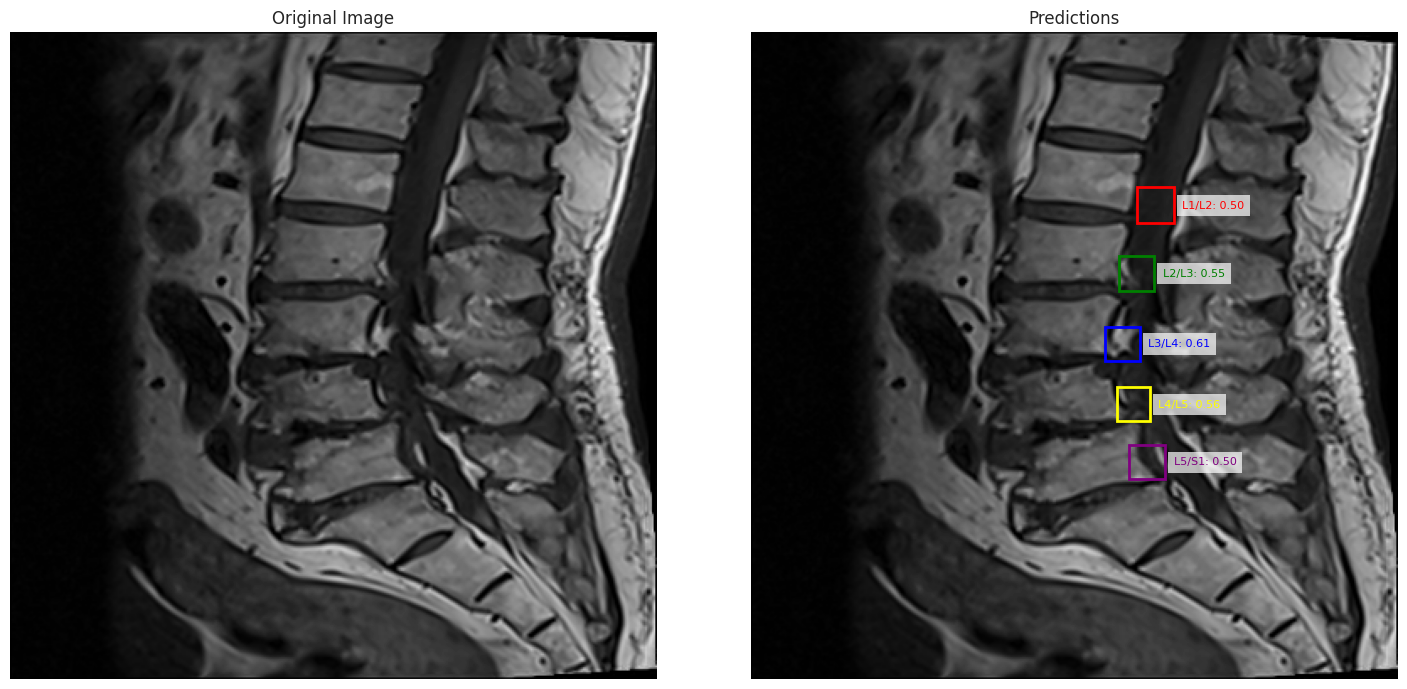


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 19.7ms
Speed: 1.0ms preprocess, 19.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.54
Found L2/L3 with confidence 0.56
Found L3/L4 with confidence 0.54
Found L4/L5 with confidence 0.52
Found L5/S1 with confidence 0.54


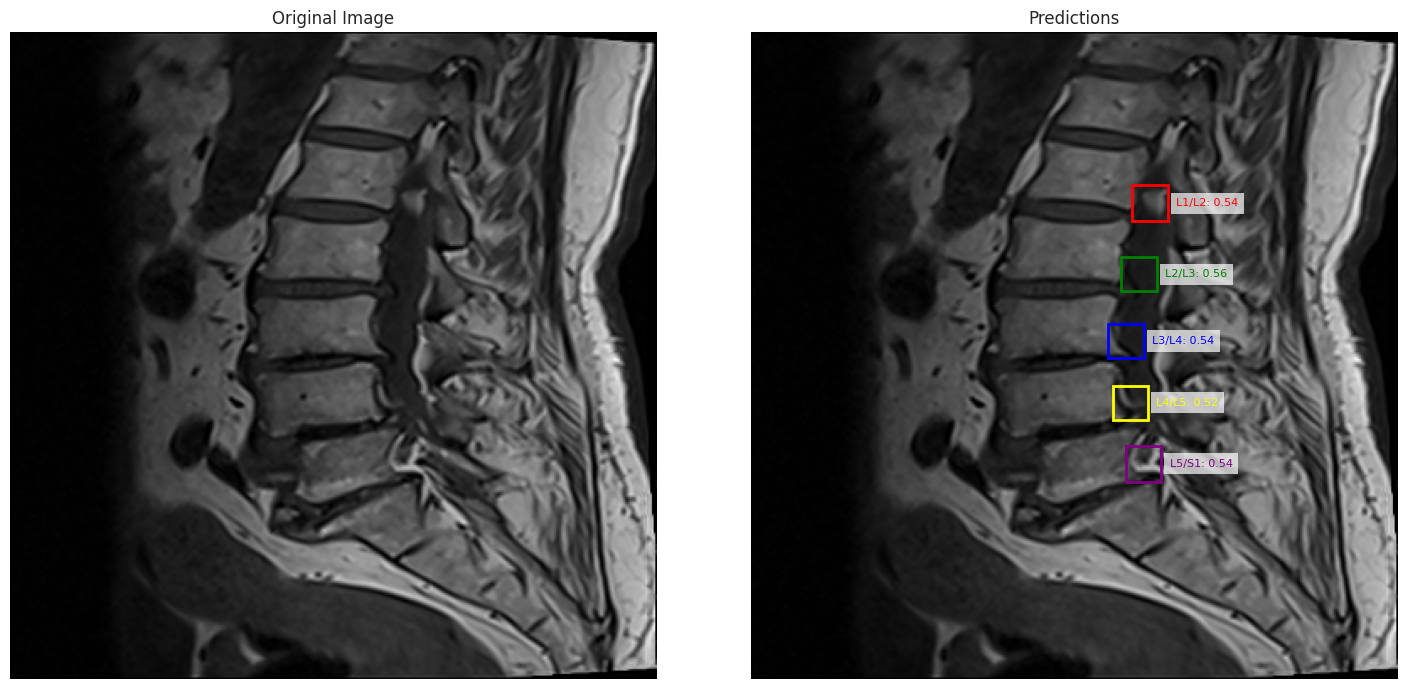


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 19.3ms
Speed: 1.0ms preprocess, 19.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.56
Found L2/L3 with confidence 0.57
Found L3/L4 with confidence 0.63
Found L4/L5 with confidence 0.50
Found L5/S1 with confidence 0.47


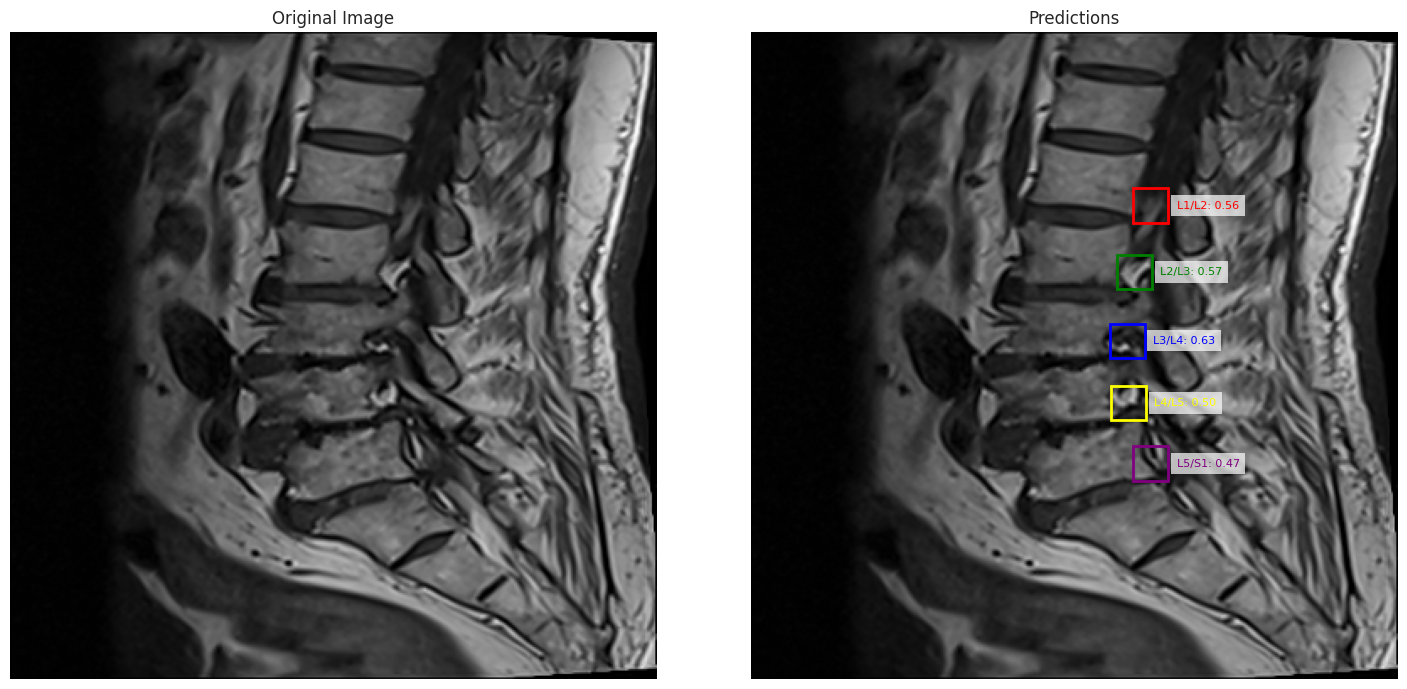


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 19.3ms
Speed: 1.0ms preprocess, 19.3ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.50
Found L2/L3 with confidence 0.51
Found L3/L4 with confidence 0.50
Found L4/L5 with confidence 0.45
Found L5/S1 with confidence 0.50


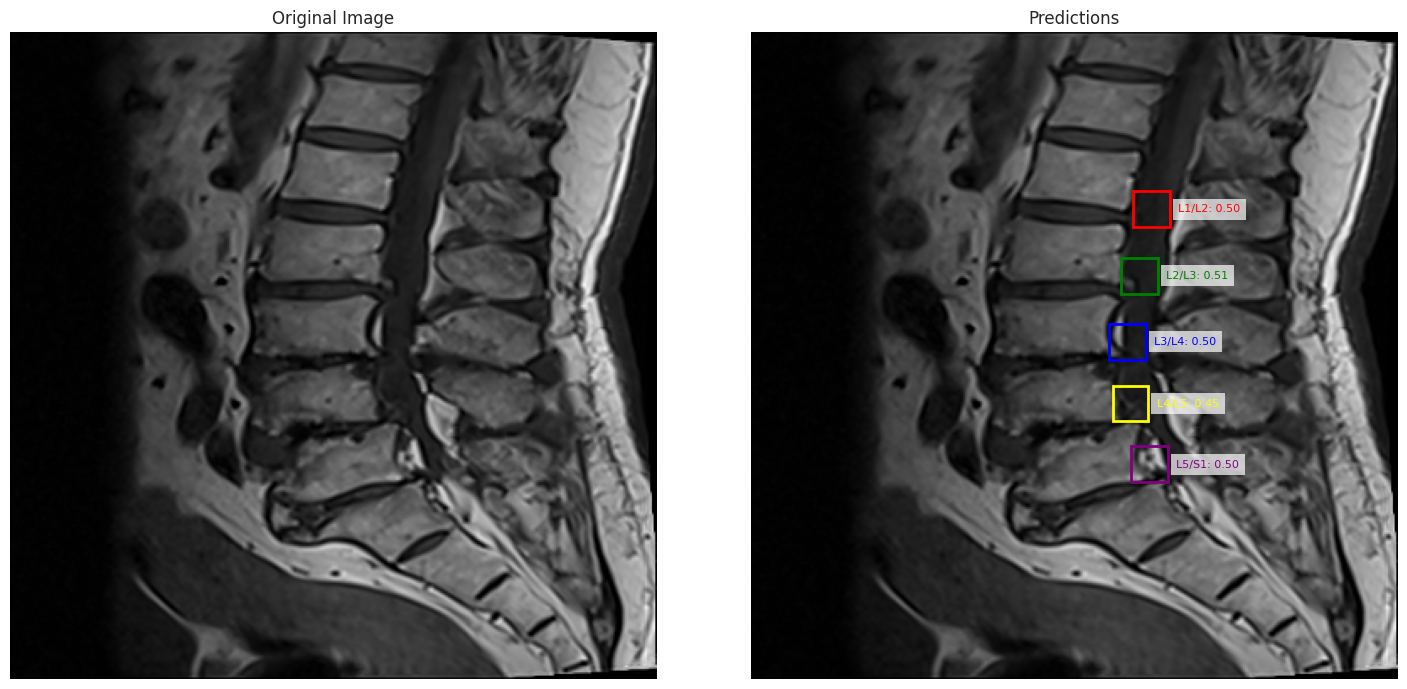


0: 384x384 1 L1/L2, 1 L2/L3, 1 L4/L5, 1 L5/S1, 21.5ms
Speed: 1.0ms preprocess, 21.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.45
Found L2/L3 with confidence 0.51
Found L4/L5 with confidence 0.29
Found L5/S1 with confidence 0.50


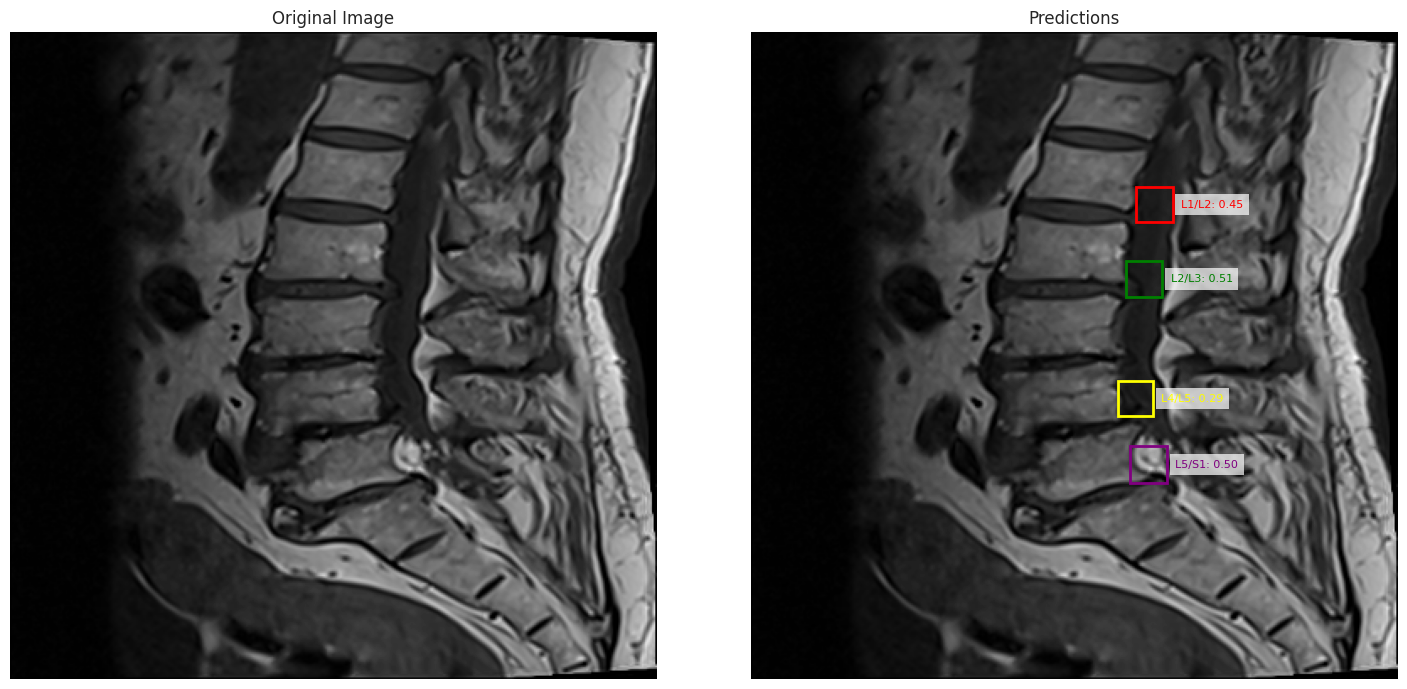


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 21.5ms
Speed: 0.9ms preprocess, 21.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.60
Found L2/L3 with confidence 0.53
Found L3/L4 with confidence 0.59
Found L4/L5 with confidence 0.48
Found L5/S1 with confidence 0.50


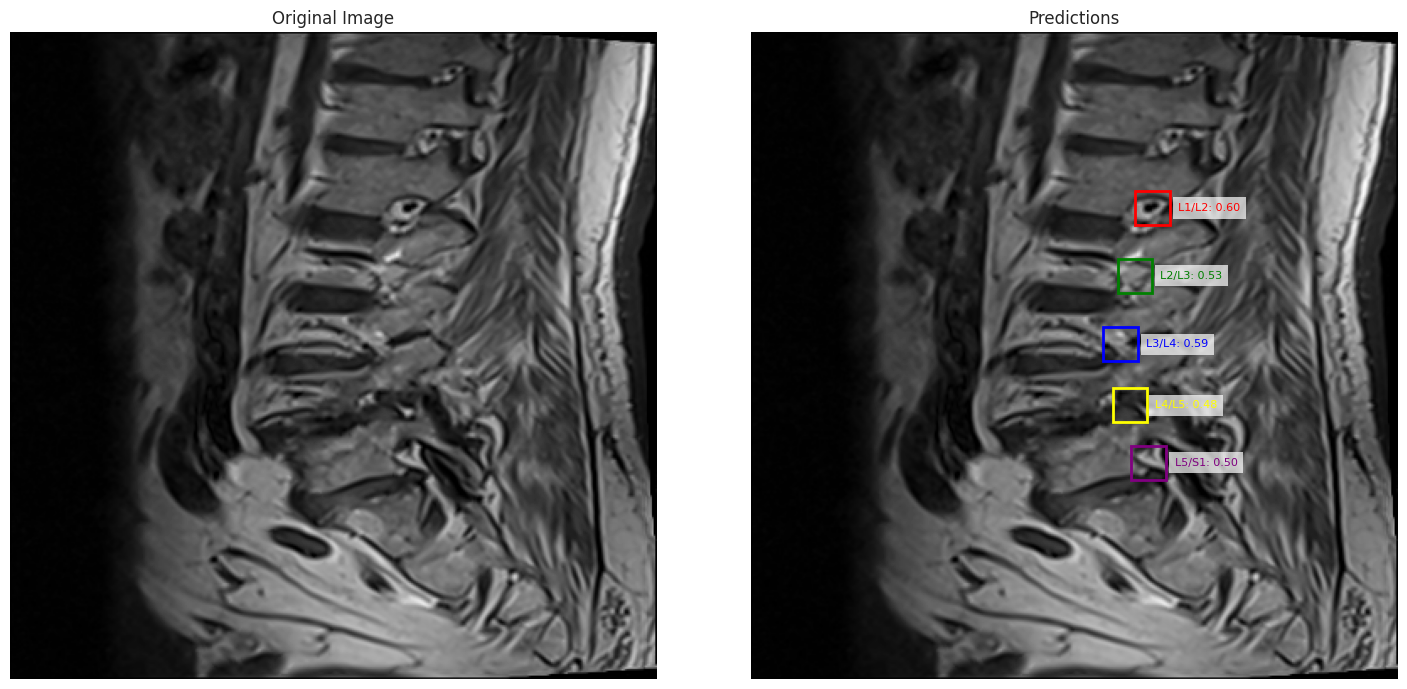


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 21.5ms
Speed: 1.0ms preprocess, 21.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.30
Found L2/L3 with confidence 0.33
Found L3/L4 with confidence 0.49


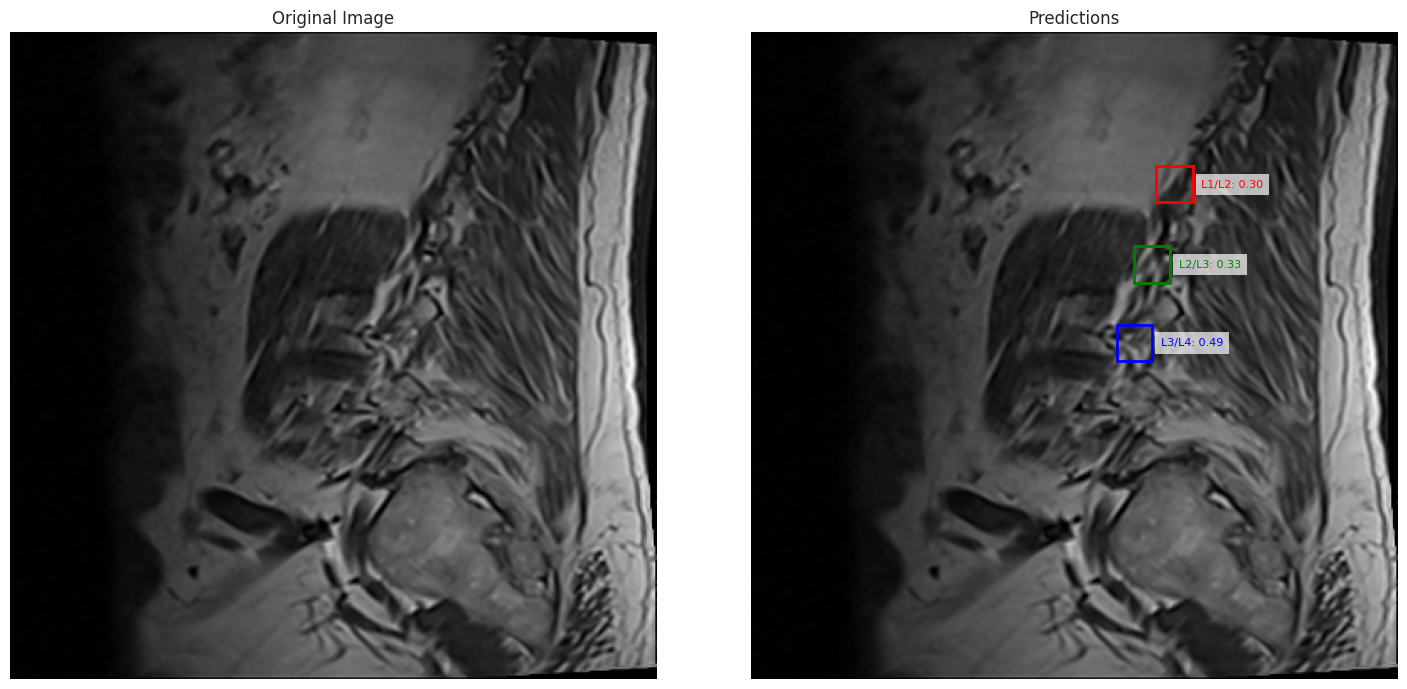


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 21.5ms
Speed: 0.9ms preprocess, 21.5ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.55
Found L2/L3 with confidence 0.65
Found L3/L4 with confidence 0.59
Found L4/L5 with confidence 0.56
Found L5/S1 with confidence 0.53


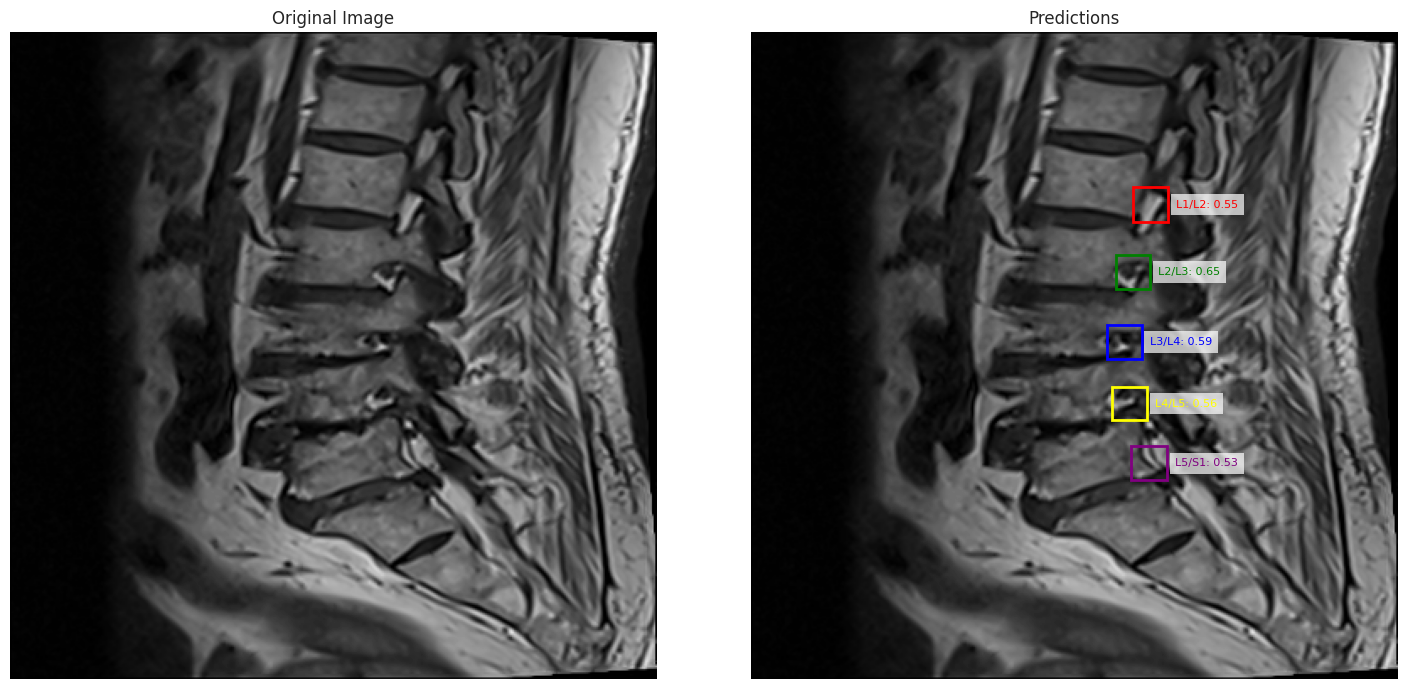


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 21.6ms
Speed: 1.0ms preprocess, 21.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.27
Found L2/L3 with confidence 0.37
Found L3/L4 with confidence 0.60
Found L4/L5 with confidence 0.37


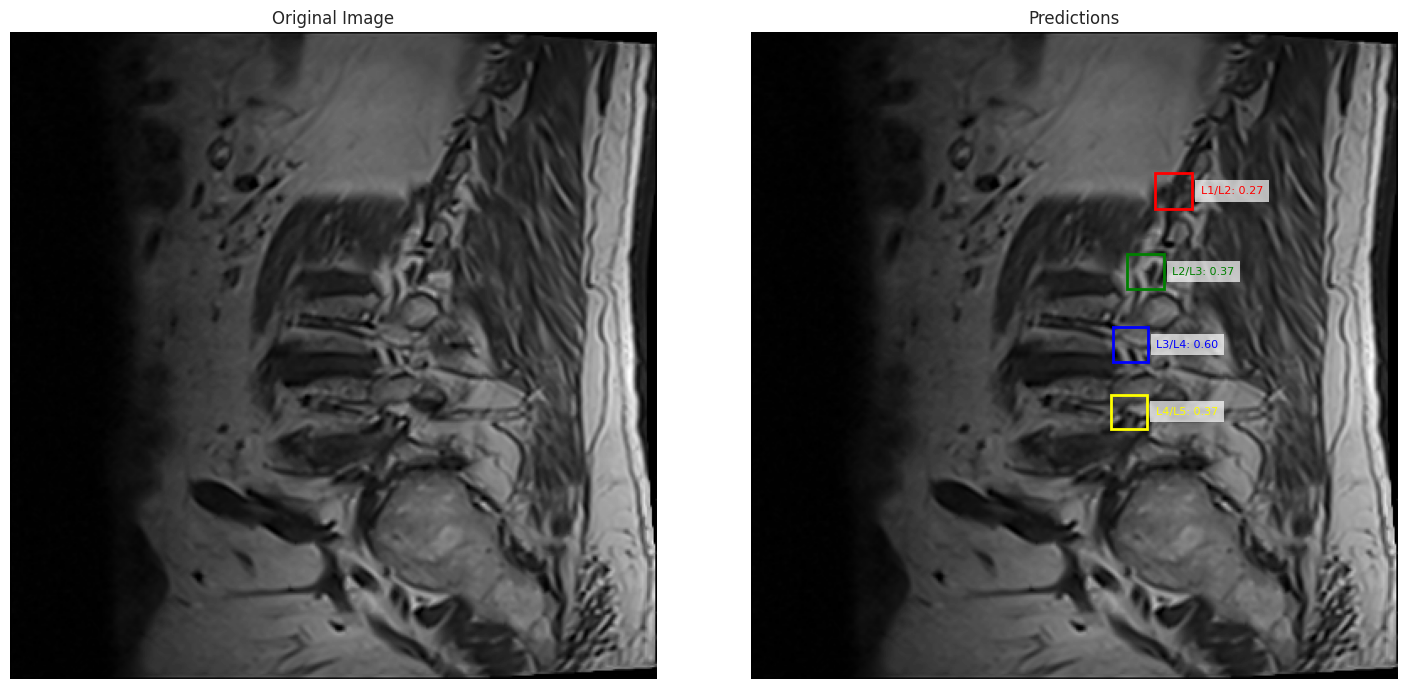


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 21.6ms
Speed: 1.0ms preprocess, 21.6ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.56
Found L2/L3 with confidence 0.54
Found L3/L4 with confidence 0.57
Found L4/L5 with confidence 0.52
Found L5/S1 with confidence 0.45


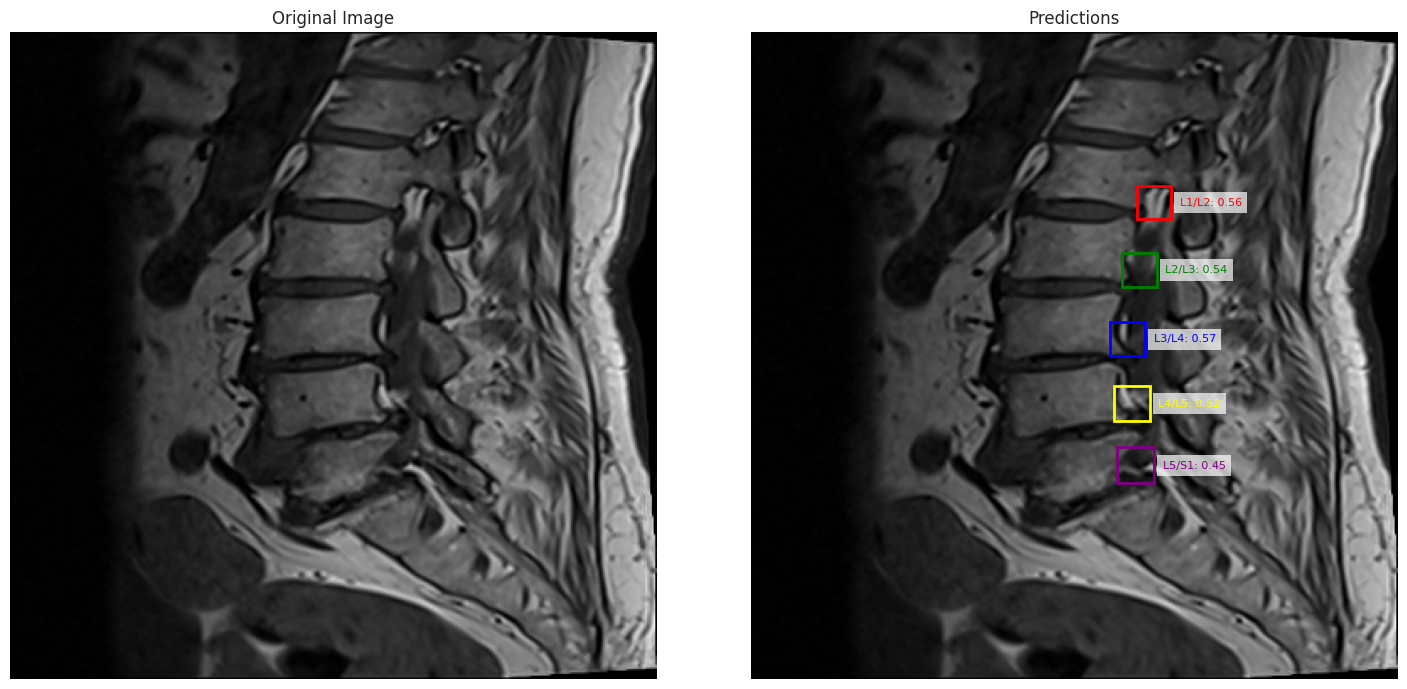


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 21.6ms
Speed: 1.0ms preprocess, 21.6ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.54
Found L2/L3 with confidence 0.55
Found L3/L4 with confidence 0.61
Found L4/L5 with confidence 0.53
Found L5/S1 with confidence 0.49


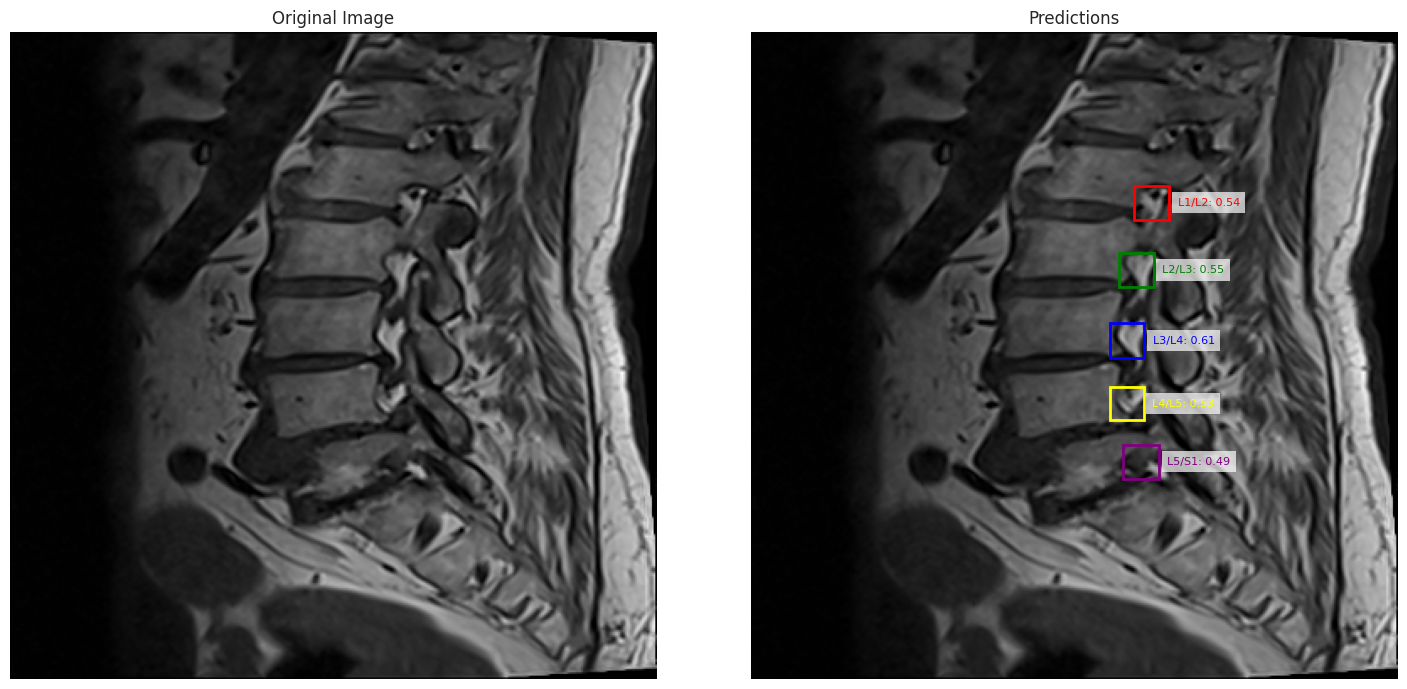


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 21.5ms
Speed: 1.0ms preprocess, 21.5ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.55
Found L2/L3 with confidence 0.53
Found L3/L4 with confidence 0.64
Found L4/L5 with confidence 0.53
Found L5/S1 with confidence 0.47


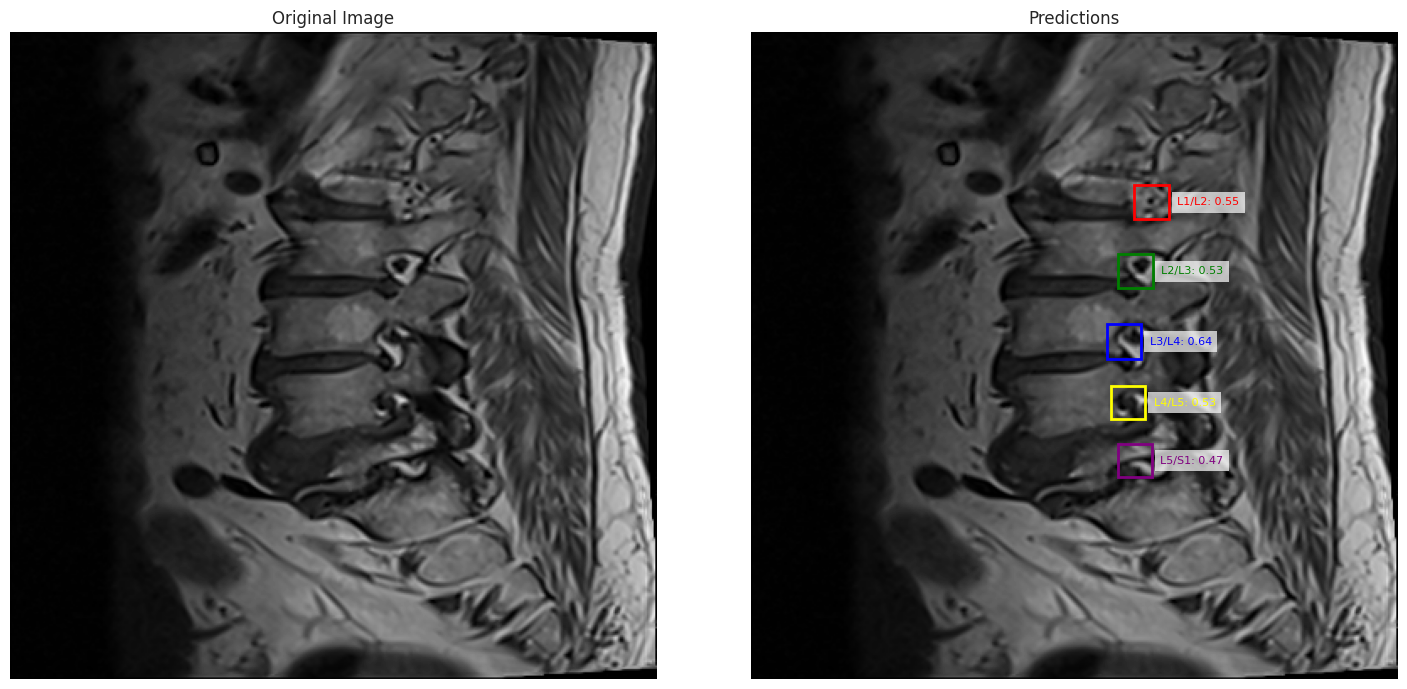


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 21.7ms
Speed: 1.0ms preprocess, 21.7ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.49
Found L2/L3 with confidence 0.54
Found L3/L4 with confidence 0.68
Found L4/L5 with confidence 0.55
Found L5/S1 with confidence 0.30


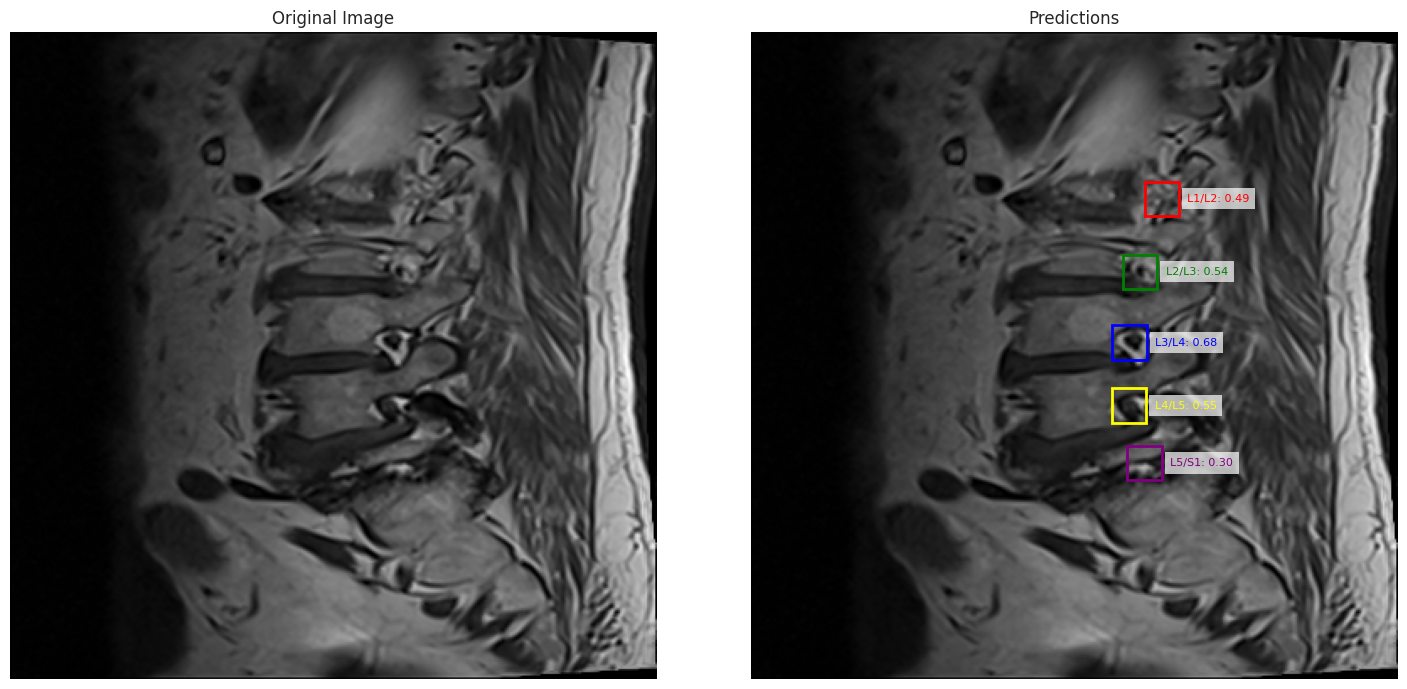


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 21.4ms
Speed: 1.0ms preprocess, 21.4ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.53
Found L2/L3 with confidence 0.52
Found L3/L4 with confidence 0.63
Found L4/L5 with confidence 0.55
Found L5/S1 with confidence 0.51


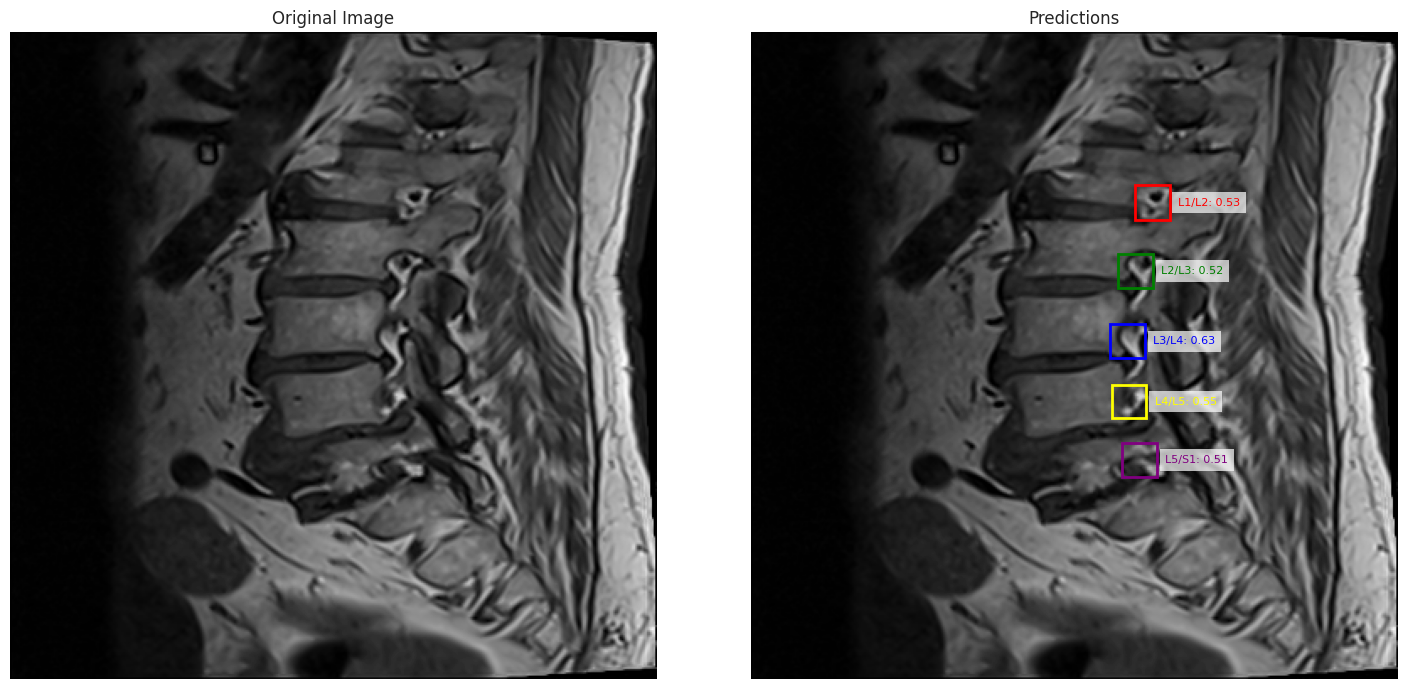


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 31.5ms
Speed: 1.0ms preprocess, 31.5ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.55
Found L2/L3 with confidence 0.60
Found L3/L4 with confidence 0.51
Found L4/L5 with confidence 0.53
Found L5/S1 with confidence 0.51


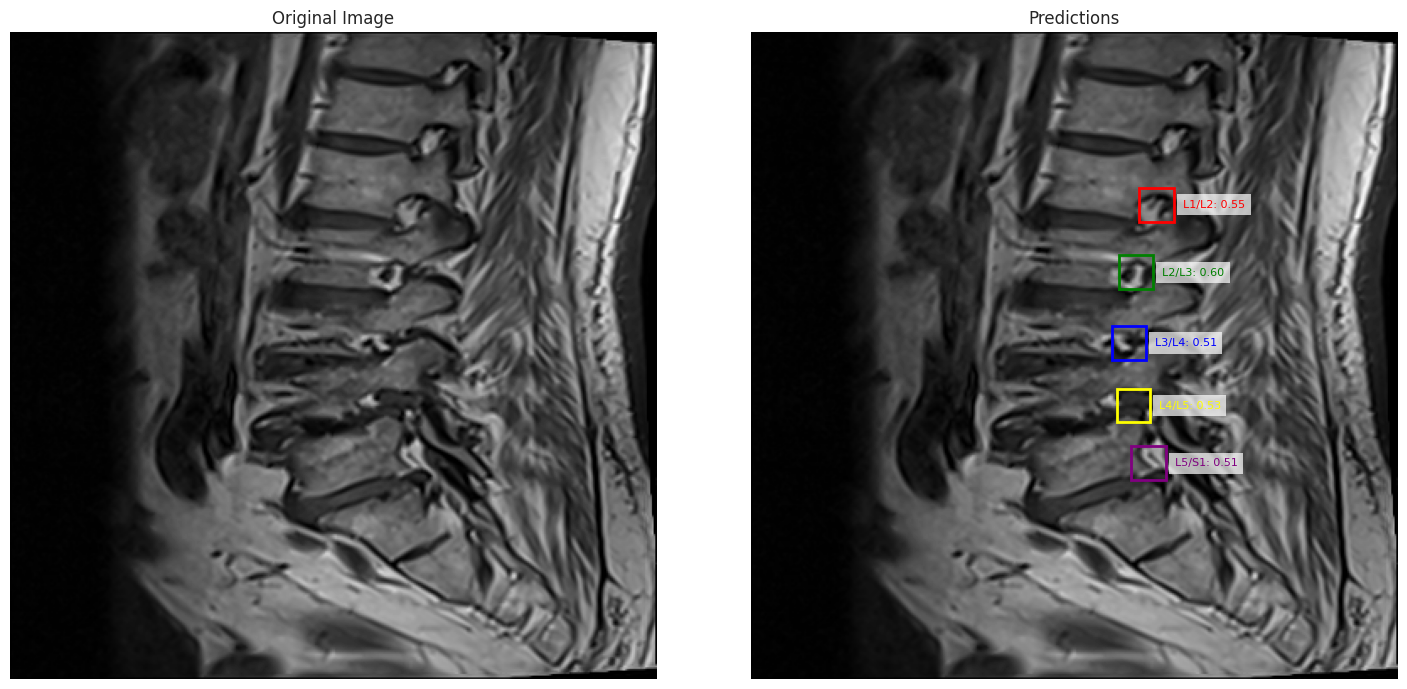


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 26.0ms
Speed: 1.2ms preprocess, 26.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.41
Found L2/L3 with confidence 0.53
Found L3/L4 with confidence 0.67
Found L4/L5 with confidence 0.60
Found L5/S1 with confidence 0.37


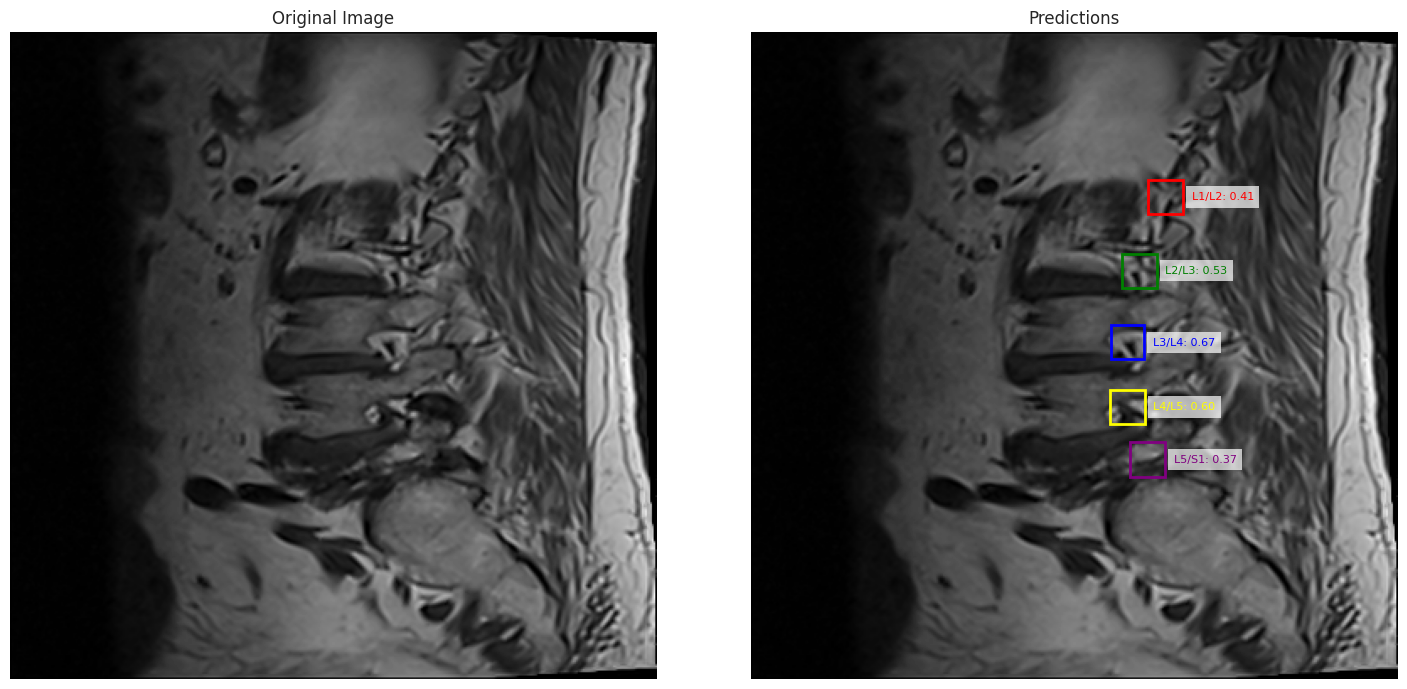


0: 384x384 1 L1/L2, 1 L2/L3, 1 L3/L4, 1 L4/L5, 1 L5/S1, 21.6ms
Speed: 0.9ms preprocess, 21.6ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 384)
Found L1/L2 with confidence 0.52
Found L2/L3 with confidence 0.55
Found L3/L4 with confidence 0.59
Found L4/L5 with confidence 0.44
Found L5/S1 with confidence 0.50


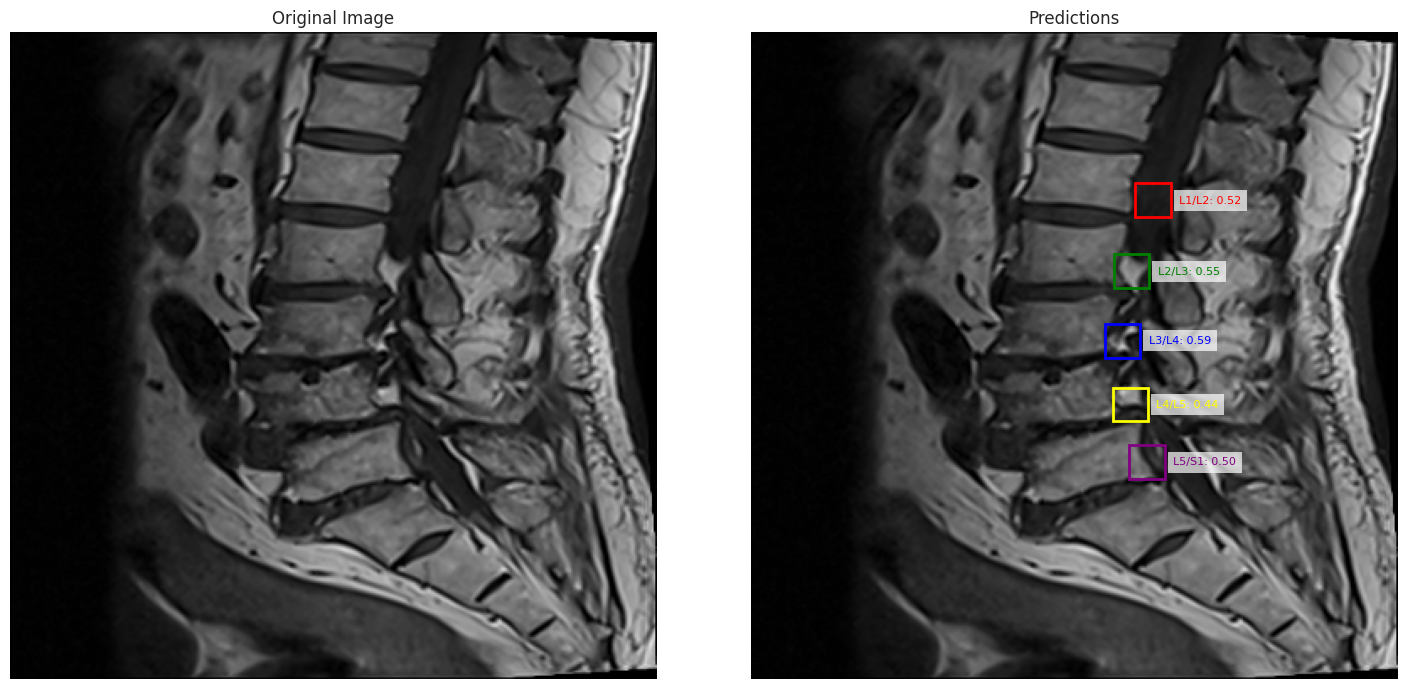

In [12]:
# Usage example for Sagittal T1:
image_paths = glob.glob('/kaggle/input/rsna-2024-lumbar-spine-degenerative-classification/train_images/4646740/3486248476/*.dcm')
process_multiple_images(image_paths, '/kaggle/working/sagittal_t1_spine_detector.pt')